# Multivariate n-lagged Random Forest  

From:  https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

Random Forest models leverage the value of many trained decision trees - making it an ensemble technique - to come up with an estimator that delivers the best balance between goodness of fit (low bias) and generalization (low variance).  In regression modelling this means averaging the output of the estimates, while in classification this means a "win by votes".  

Timeseries data can be processed to be modelled using supervised learning algotithms like Random Forest.  The data must be "lagged", that is, the model is prompted to predict a target at time t using information from time t-1 (or t-n if n lags are imposed).  And this can be done for an autoregression, where a target is predicted based only on past values of itself, or it can be done for a multivariate scenario where a target variable is predicted on past values of itself and past values for the feature variables that impact on the target.

Here is an overview of the steps carried out in this effort:
* The raw dataset must be lagged to the desired lag value, and the lagged versions of the variables must be collated for input
> For the multivariate exercise, a lag of 1 will first be attempted to get a successful execution, then 4, then perhaps 8.
* The variables are split into training and test datasets
* The RandomForest is configured and fit on training data
* Predicted values are generated as "one-step" walking forecast predictions on a model re-fit with the training dataset and the last-used test data point/row.  
* These one-step walking forecast predictions are compared to their actual observations for plotting and the calculation of mean absolute error (MAE).  This mirrors a set-up where models are updated real-time on observed data as it is available. 
* Predictions are also produced for a "static model" that is fit only once on the training data, and the test data is input in one step to obtain the predictions.  Plots of the predicted and expected values are produced and the MAE is calculated.

### Stationarity   

In the eda notebooks, the data was found to be stationary by the Augmented Dickey-Fuller test.

https://datascience.stackexchange.com/questions/30362/checking-for-stationarity-in-lstm#:~:text=You%20may%20want%20to%20force,you%20a%20boost%20in%20performance.  

To check for stationarity in Python, consult the following:  
https://machinelearningmastery.com/time-series-data-stationary-python/  

Tests for stationarity, generally:  

"There are various statistical tests to check stationarity, including the Augmented Dickey-Fuller (ADF) test and the Kwiatkowski-Phillips-Schmidt-Shin (KPSS) test. The ADF test is a widely used test for checking the stationarity of a time series, and it checks for the presence of a unit root in the data."  (Analytics Vidhya)  

### Predicting on a Real-Time Fitted Model  

One can imagine two scenarios, generally:  

1.  One where a model is fit on a large and rich set of data, the fitted model is used for any new observations that come in, and a model refresh occurs after some set of conditions have been met (time, significant change in process, model performance degradation, etc).

2.  Another where a model is fit also on a fairly large and rich set of data, it generates predictions, but as new observations are recorded, the model is re-fit with the prior history and the new observations, which then generates predictions on a presumably more up-to-date model.

The below presents the second scenario and its results, and below this is the first scenario, "static model" predictions.  Comments on the pitfalls of real-time model refitting are found in the second section.

In [7]:
import numpy as np
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot
from pprint import pprint

### Multivariate Random Forest Timeseries Model with lag 1

[[ 4.00000000e+00  1.22600000e-01  1.03725000e-01 ...  1.40128571e+01
   2.62857143e+00  5.00000000e+00]
 [ 5.00000000e+00  1.69900000e-01  1.42175000e-01 ...  1.53728571e+01
   2.37142857e+00  4.00000000e+00]
 [ 4.00000000e+00  3.22500000e-02  1.72966700e-01 ...  1.68485714e+01
   2.30000000e+00  3.00000000e+00]
 ...
 [ 3.00000000e+00 -3.80000000e-02 -1.68333300e-02 ...  1.46628571e+01
   2.71428571e+00  1.00000000e+00]
 [ 1.00000000e+00 -1.55200000e-01 -5.27500000e-02 ...  1.41842857e+01
   2.18571429e+00  3.00000000e+00]
 [ 3.00000000e+00  1.80000000e-03 -5.27500000e-02 ...  1.38585714e+01
   2.78571429e+00  5.00000000e+00]]
>expected=2.0, predicted=9.5
>expected=6.0, predicted=7.7
>expected=8.0, predicted=6.5
>expected=5.0, predicted=8.2
>expected=1.0, predicted=6.3
>expected=2.0, predicted=3.9
>expected=3.0, predicted=4.5
>expected=4.0, predicted=4.1
>expected=3.0, predicted=7.0
>expected=1.0, predicted=3.9
>expected=3.0, predicted=4.6
>expected=5.0, predicted=4.8
MAE: 2.604


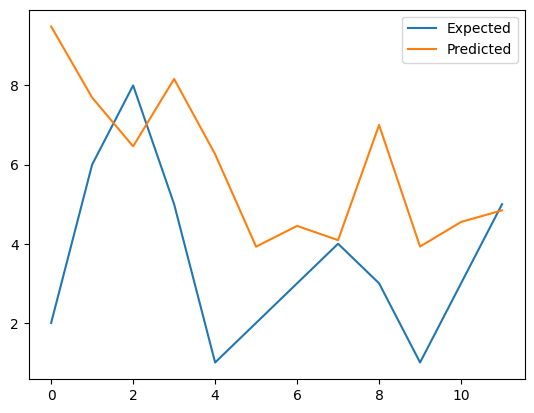

In [2]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
# you get all of the columns, so all the y's at time lags (however many you've set) and the y at time t
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]	# added iloc hoping it'll fix the index error / briefly removed to see impact after fixing the column selection from series_to_supervised

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	# i.e. input is lagged y's, output is y(t)
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 1 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks) # one time lag for my univariate set-up; we'll try other lags on the multivariate set-up once it's running ok

# Select the proper columns from the output of series_to_supervised
# at 1 target and 14 features, you should get 15 columns lagged and 15 columns unlagged, for 30 columns in total.  We'd keep the lagged ones plus the unlagged target columns.  Will require careful handling:
n_obs = n_weeks * n_features
# grabs columns 0 to 14, the lagged output and inputs, and then only the 15th column from the end which is the unlagged output
# Select the relevant chunks of data
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))  # no longer a "nice-looking" dataframe with column headers now, but a list of arrays, which likely works better in walk_forward_validation (and its functions)
print(data_recombined)				

# evaluate
mae, y, yhat = walk_forward_validation(data_recombined, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Multivariate Random Forest Timeseries Model with lag 4

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
>expected=2.0, predicted=10.8
>expected=6.0, predicted=7.3
>expected=8.0, predicted=6.6
>expected=5.0, predicted=5.5
>expected=1.0, predicted=5.2
>expected=2.0, predicted=5.5
>expected=3.0, predicted=3.5
>expected=4.0, predicted=2.9
>expected=3.0, predicted=4.1
>expected=1.0, predicted=3.1
>expected=3.0, predicted=4.1
>expected=5.0, predicted=3.9
MAE: 2.228


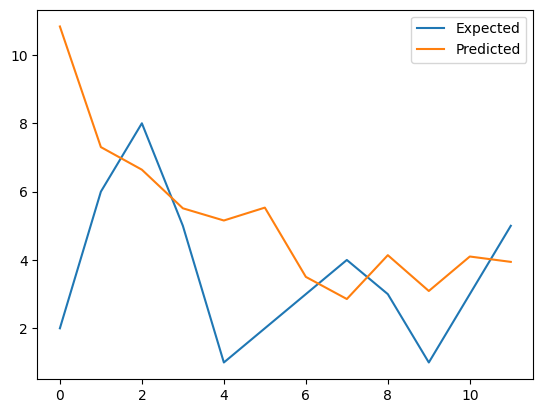

In [3]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)				

# evaluate
mae, y, yhat = walk_forward_validation(data_recombined, 12)
print('MAE: %.3f' % mae)
# plot expected vs predicted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### Predicting on a Static Model  

The below mimics what's done above in the initial set-up where the model is trained on training data (after much processing), but now rather than:  
a) feed it one testX row at at time to do a real-time re-fit of the model and generate predictions one step at a time, instead we  
b) feed it the entire testX set of rows to get a 'static model' prediction, yhat_static, and get the model error on that   

In many situations, a real-time model re-fit may not be feasible if the computational load is too big, or data cannot be obtained in a timely manner to allow for real-time model updates.  Additionally, real-time model updates come with the additional burden of due diligence:  guardrails must be instituted to ensure 'rogue data' or significant drift in the process being modelled doesn't result in a model that produces significantly erroneous results.  Monitoring error would only be one part of the safeguarding scheme.  There would have to be additional supports like monitoring data quality real-time, among other protections.

Careful not to feed it [test_X], you want to feed it only (test_X) if you're sending it all of testX at a time.

The below trains a model with lag 4 as this yielded a lower MAE than the lag 1 model's MAE.

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
MAE on the static model: 2.215


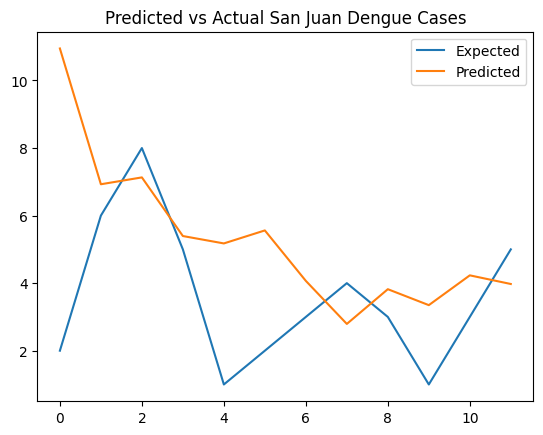

In [5]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# # Pull the data that is output from series_to_supervised
# print(data_recombined) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data_recombined, 12)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 12 to 50.  MAE went from 2.2 to 9.5, but that's ok.  Bit more in line with what I'm expecting vis-à-vis the results I'm getting from other models.  Plus now with a slighty smaller training set to fit on, and a larger test set to goof up on, it makes sense.

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
MAE on the static model: 9.517


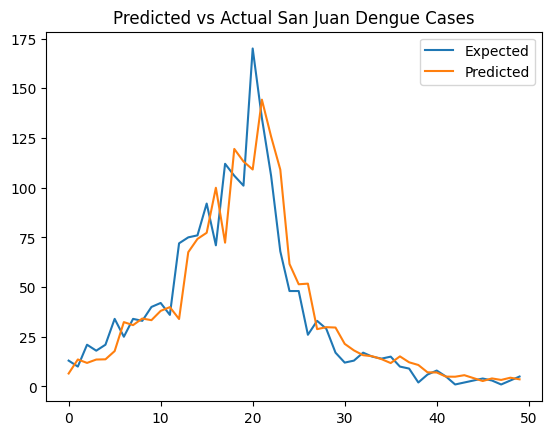

In [6]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# # Pull the data that is output from series_to_supervised
# print(data_recombined) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data_recombined, 50)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 50 to 100.  MAE 9.5 to 7.

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
MAE on the static model: 7.114


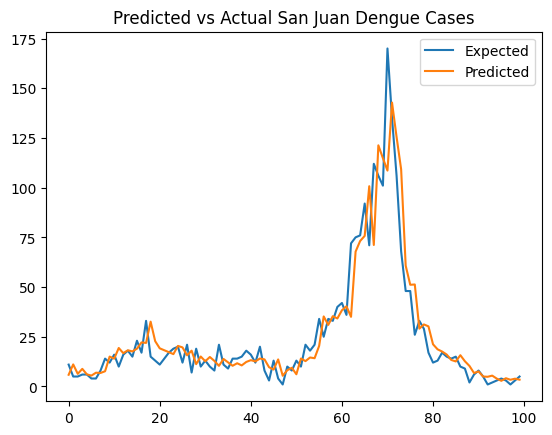

In [7]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# # Pull the data that is output from series_to_supervised
# print(data_recombined) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data_recombined, 100)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 100 to 200.  MAE 7 to 7.5.

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
MAE on the static model: 7.469


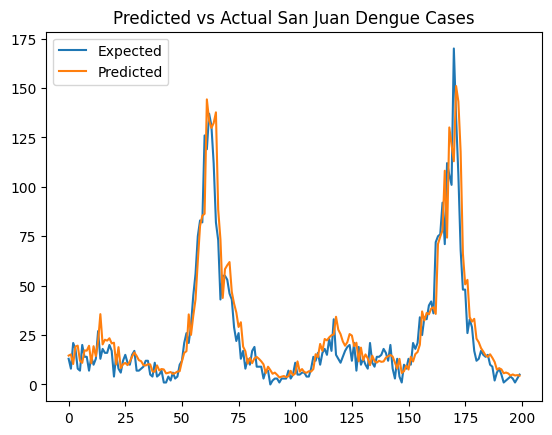

In [8]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# # Pull the data that is output from series_to_supervised
# print(data_recombined) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data_recombined, 200)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

### Trying Larger Test Sets on Static Model  

Going from 200 to 300.  MAE 7.5 to 6.4.

[[ 4.          0.1226      0.103725   ... 16.67285714  2.42857143
   6.        ]
 [ 5.          0.1699      0.142175   ... 17.21        3.01428571
   2.        ]
 [ 4.          0.03225     0.1729667  ... 17.21285714  2.1
   4.        ]
 ...
 [ 2.         -0.3214     -0.1412     ... 14.66285714  2.71428571
   1.        ]
 [ 3.          0.0449      0.02445    ... 14.18428571  2.18571429
   3.        ]
 [ 4.          0.07785    -0.0399     ... 13.85857143  2.78571429
   5.        ]]
MAE on the static model: 6.326


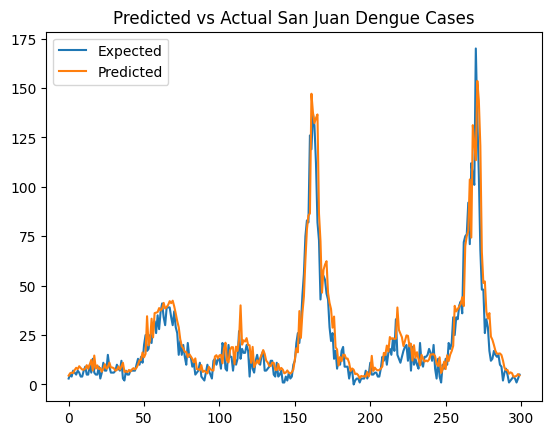

In [5]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# load the dataset
sj_df = read_csv('sj_df.csv', header=0, index_col=0)
#sj_df_cases = sj_df['total_cases'] # no longer univariate
values = sj_df.values
# transform the time series data into supervised learning
n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# Select the proper columns from the output of series_to_supervised
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# # Pull the data that is output from series_to_supervised
# print(data_recombined) # 2 columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
# takes first rows up to last n_test (12) rows, all columns (so lagged y and y(t))
train, test = train_test_split(data_recombined, 300)    
history = [x for x in train]
# the below is basically the output of series_to_supervised (data); each row made into array [y(t-1), y(t)] - it's an array (or list) of arrays
#history                                     

# Take the entire test set and assign the all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# back to the array we had before with train prior to it being fed to [x for x in train].  
# Not sure why the back and forth.  It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1] 
model_static = RandomForestRegressor(n_estimators=1000)
model_static.fit(trainX, trainy)						

# now predict y(t) using testX (last 12/n_test rows of lagged y)
yhat_static = model_static.predict(testX)					
yhat_static	
#print('>expected=%.1f, predicted=%.1f' % (testy, yhat_static))

MAE_static = mean_absolute_error(test[:, -1], yhat_static)
print('MAE on the static model: %.3f' % MAE_static)

# plot actual and predicted
pyplot.plot(test[:, -1], label='Expected')
pyplot.plot(yhat_static, label='Predicted')
pyplot.title("Predicted vs Actual San Juan Dengue Cases")
pyplot.legend()
pyplot.show()

## Hyperparameter Tuning using GridSearchCV  

What follows below is a printout of the last model's parameters, since it has a reasonable MAE given the train and test set sizes.  It provides us with a good starting point for setting up a hyperparameter tuning exercise.  

In [8]:
# Look at parameters used by our current forest
# Be darned sure the model_static being used below is the best one, ie. you run the lag 4 MV RF with test set 300 last.
print('Parameters currently in use:\n')
pprint(model_static.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


The below snippet is taken from Week 8 Day 5's lecture on Model Training and Evaluation.  The intent is to try to apply it to this random forest regressor.  The parameter grid will need to be adjusted for this model algorithm.  

The amended code for our case is beneath this block below.

In [ ]:
# Split data into a train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, train_size=0.8)

# Standardize the data using only statistics from the training set
# (always assume no knowledge of the test set for most unbiased performance estimate)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel
grid = GridSearchCV(estimator=model, param_grid=param_grid,
                    cv=k_folds, scoring='r2', verbose=1, n_jobs=-1)
grid_result = grid.fit(X_train, y_train)

best_r2 = grid_result.best_score_
best_alpha = grid_result.best_params_['alpha']
best_l1_ratio = grid_result.best_params_['l1_ratio']
print(
    f'The best hyperparameter settings achieve a cross-validated R^2 of: {best_r2}\nAlpha:\t{best_alpha}\nL1 ratio:\t{best_l1_ratio}')

# Using the best hyperparameters, retrain on the entire train set and evaluate on the test set
# Sklearn automatically retrains the model on the whole training set following cross-validation using the best hyperparameters
best_model = grid_result.best_estimator_
y_pred = best_model.predict(X_test)
r2_test = r2_score(y_test, y_pred)
print(f'R^2 on the test set:\t{r2_test}')

Amending for our situation.

In [ ]:
# convert series to supervised learning for multivariate scenarios
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	# notice n_vars is now used to account for the columns in a multivariate dataset
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# split dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

sj_df = read_csv('sj_df.csv', header=0, index_col=0)
values = sj_df.values

n_weeks = 4 # lag desired
n_features = 15 # 1 target and 14 features
data = series_to_supervised(values, n_in=n_weeks)

# column selection
n_obs = n_weeks * n_features
X_lagged = data.iloc[:, :n_obs].values  # lagged input data (target and features)
y_lagged = data.iloc[:, -n_features].values # unlagged target
# Combine the above selections
data_recombined = np.column_stack((X_lagged, y_lagged))
print(data_recombined)	# X(fill) columns (y(t-1), y(t)) as expected

# Split the data into a training set and a test set; the training set is used to fit the model
train, test = train_test_split(data_recombined, 300)    
history = [x for x in train]

# Take the entire test set and assign all but the last column to X as the features (lagged y) and the last column is Y as the target (y(t))
testX, testy = test[:, :-1], test[:, -1]

# history ends up as 'train' in the random_forest_forecast function. Appropriate substitutions made.
# It's the 2 columns of training data:, y(t-1), y(t).
history = asarray(history)        
# again, history subbed in per parameters fed to random_forest_forecast function; keeps all rows, but separates lagged y and y(t)
trainX, trainy = history[:, :-1], history[:, -1]

# parameter grid suitable for random forest regression
param_grid = {'max_depth': [3, 5, 10],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [750, 1000, 1250],
             }

rf = RandomForestRegressor()

# verbose=1 -> print results, n_jobs=-1 -> use all processors in parallel
grid = GridSearchCV(estimator=rf, param_grid=param_grid,
                    cv=3, scoring='neg_mean_absolute_error', verbose=1, n_jobs=-1, refit=True)

grid.fit(trainX, trainy)

best_train_mae = grid.best_score_
best_params = grid.best_params_

print(
    f'The best hyperparameter settings achieve a cross-validated MAE of: {best_train_mae}.')

# Using the best hyperparameters, retrain on the entire train set and evaluate on the test set
# Sklearn automatically retrains the model on the whole training set following cross-validation using the best hyperparameters (refit=True, right?)

best_grid_model = grid.best_estimator_ # Not sure why we do this, I though refit=True made sure the result was the best fit trained on the *whole* set (train+valid, from train)
y_pred = best_grid_model.predict(testX)
MAE_test = mean_absolute_error(y_test, testy)
print(f'MAE on the test set:\t{MAE_test}')

Haven't run yet.  Back notebooks up to github in case something goes sideways.